In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [95]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
inspector = inspect(engine)

In [14]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


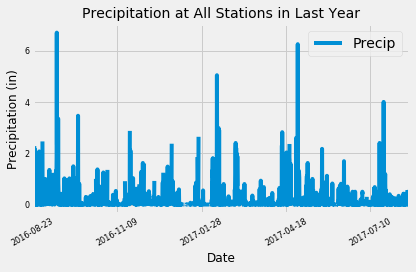

In [171]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

lastDayOfData = session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all()[0][0]
oneYearAgo = dt.datetime.strptime(lastDayOfData, '%Y-%m-%d')-dt.timedelta(days=366)
dateQuery = dt.datetime.strftime(oneYearAgo,'%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores

last12pcpn = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > dateQuery)

# Save the query results as a Pandas DataFrame and set the index to the date column

date = [day[0] for day in last12pcpn]
pcpn = [day[1] for day in last12pcpn]

df = pd.DataFrame({'Date':date,'Precip':pcpn}).set_index('Date')

# Sort the dataframe by date

df = df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data

df.plot(y='Precip',rot=30,fontsize=8)
plt.ylabel("Precipitation (in)",fontsize=12)
plt.xlabel("Date",fontsize=12)
plt.title('Precipitation at All Stations in Last Year',fontsize=14)
plt.tight_layout()
plt.savefig('./myImages/precip.png',dpi=300)
plt.show()

In [74]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [75]:
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [79]:
# Design a query to show how many stations are available in this dataset?

stationCount = session.query(func.count(func.distinct(Station.id)))
stationCount.all()

[(9)]

In [107]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stationActivity = session.query(Measurement.station,func.count(Measurement.date)).\
                group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
stationActivity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [112]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

mostActive = stationActivity[0][0]
tempStats = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                    filter(Measurement.station == mostActive).all()
tempStats

[(54.0, 85.0, 71.66378066378067)]

In [1]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


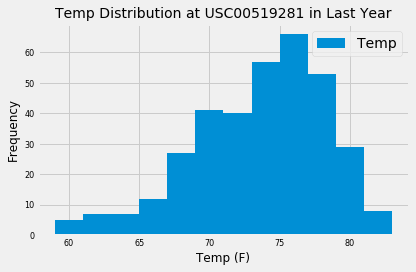

In [132]:
# Get a count of temperature obs per station and place in descending order of the count
countTobs = session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
                        order_by(func.count(Measurement.tobs).desc()).all()

# Grab the station with the most temp obs
mostTobs = countTobs[0][0]

# Grab the temp obs for the identified station and only get the last year using our old dateQuery variable
temps = session.query(Measurement.tobs).filter(Measurement.station == mostTobs).\
                filter(Measurement.date > dateQuery).all()

# Convert to a list for dataframing
tempList = [ob[0] for ob in temps]

df = pd.DataFrame({'Temp':tempList})
df.plot(kind='hist',y='Temp',bins=12,fontsize=8)
plt.title(f'Temp Distribution at {mostTobs} in Last Year', fontsize=14)
plt.xlabel('Temp (F)',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.tight_layout()
plt.savefig('./myImages/tempHistogram.png',dpi=300)
plt.show()

In [134]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [136]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

tripTempStats = calc_temps('2017-06-10','2017-06-16')
tripTempStats

[(72.0, 76.91304347826087, 83.0)]

<IPython.core.display.Javascript object>


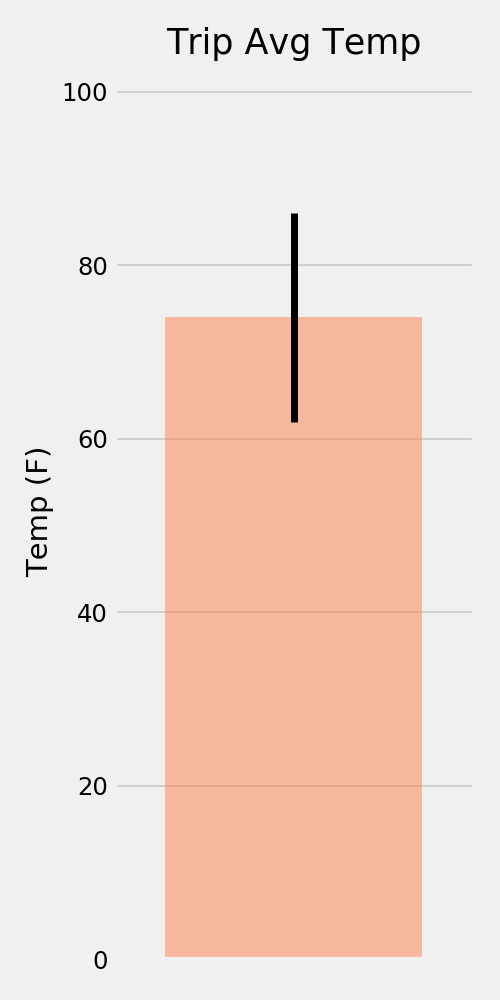

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


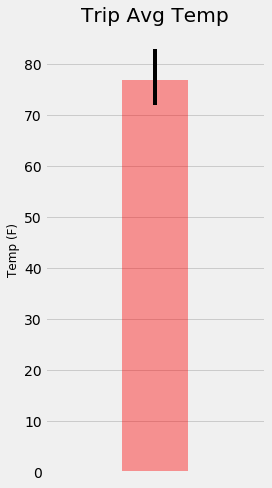

In [163]:
fig,ax = plt.subplots(figsize=(4,7))
plt.bar(0.5,tripTempStats[0][1],width=0.3,color='red',alpha=0.4,yerr=[[tripTempStats[0][1]-tripTempStats[0][0]],
                                                           [tripTempStats[0][2]-tripTempStats[0][1]]])
plt.xlim([0,1])
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)', fontsize=12)
plt.tight_layout()
plt.savefig('./myImages/tripTemp.png')
plt.show()

#### Rainfall Calculation

In [168]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Measurement.station,func.sum(Measurement.prcp),Station.name,Station.latitude,
             Station.longitude,Station.elevation).group_by(Measurement.station).\
                filter(Measurement.station == Station.station).filter(Measurement.date >= '2017-06-10').\
                filter(Measurement.date <= '2017-06-16').order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  4.76,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  2.6700000000000004,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00514830',
  1.6500000000000001,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00513117', 1.46, 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00519523',
  0.6100000000000001,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00519397',
  0.13999999999999999,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('USC00517948', None, 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

### Temp Analysis 1

In [234]:
# Get all temperatures from June
juneTemps = session.query(Measurement.station,func.avg(Measurement.tobs))\
                .filter(func.strftime("%m",Measurement.date) == "06")\
                .group_by(Measurement.station).all()

# Get all temperatures from December
decTemps = session.query(Measurement.station,func.avg(Measurement.tobs))\
                .filter(func.strftime("%m",Measurement.date) == "12")\
                .group_by(Measurement.station).all()

In [236]:
decTemps, juneTemps

([('USC00511918', 69.6842105263158),
  ('USC00513117', 71.06944444444444),
  ('USC00514830', 73.2247191011236),
  ('USC00516128', 69.29126213592232),
  ('USC00517948', 71.8348623853211),
  ('USC00518838', 72.42105263157895),
  ('USC00519281', 69.90322580645162),
  ('USC00519397', 71.10952380952381),
  ('USC00519523', 72.43333333333334)],
 [('USC00511918', 74.13939393939394),
  ('USC00513117', 74.05084745762711),
  ('USC00514830', 76.00537634408602),
  ('USC00516128', 71.9372197309417),
  ('USC00517948', 76.6554054054054),
  ('USC00518838', 73.39473684210526),
  ('USC00519281', 73.27118644067797),
  ('USC00519397', 77.55932203389831),
  ('USC00519523', 76.66810344827586)])

In [237]:
# Append the values in our returned tuples to lists for each month
juneTempList, decTempList = [],[]

for day in juneTemps:
    
    juneTempList.append(day[1])
    
for day in decTemps:
    
    decTempList.append(day[1])

In [240]:
# Import the paired t-test from scipy
# I think that we should be using the paired t-test since we are comparing the same stations,
# just at different times of year

from scipy.stats import ttest_rel

**Based on our t-test p-value (in the cell below), there does appear to be a statistically significant difference between the mean temperature in June vs the mean in December. While Hawaii does have a tropical climate (with muted temperature variation), there is at least enough change between the months to give us this statistical significance.**

In [241]:
# Run the paired t-test
ttest_rel(juneTempList,decTempList)

Ttest_relResult(statistic=6.95696617044294, pvalue=0.00011759380231523222)

In [180]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [200]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

normals = []

# Set the start and end date of the trip

startDate = "2017-06-10"
endDate = "2017-06-16"

# Use the start and end date to create a range of dates

numDays = (dt.datetime.strptime(endDate,"%Y-%m-%d") - dt.datetime.strptime(startDate,"%Y-%m-%d")).days
dayList = []

i = 0
while (i <= numDays):
    dayList.append(dt.datetime.strptime(startDate,"%Y-%m-%d")+dt.timedelta(days=i))
    i += 1

# Stip off the year and save a list of %m-%d strings

formattedDayList = list(map(lambda x: dt.datetime.strftime(x,'%m-%d'), dayList))

# Loop through the list of %m-%d strings and calculate the normals for each date
for day in formattedDayList:
    
    normals.append(daily_normals(day)[0])
    
normals

[(68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864406779, 81.0),
 (67.0, 75.40350877192982, 81.0),
 (69.0, 75.41379310344827, 81.0)]

In [202]:
normalsDF = pd.DataFrame(normals,columns=['Min','Avg','Max'])

In [206]:
normalsDF['Date'] = formattedDayList
normalsDF.set_index('Date',inplace=True)

In [207]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normalsDF

,Min,Avg,Max
Date,,,
06-10,68.0,75.142857,81.0
06-11,69.0,76.019608,84.0
06-12,66.0,75.666667,83.0
06-13,68.0,75.666667,81.0
06-14,69.0,75.627119,81.0
06-15,67.0,75.403509,81.0
06-16,69.0,75.413793,81.0


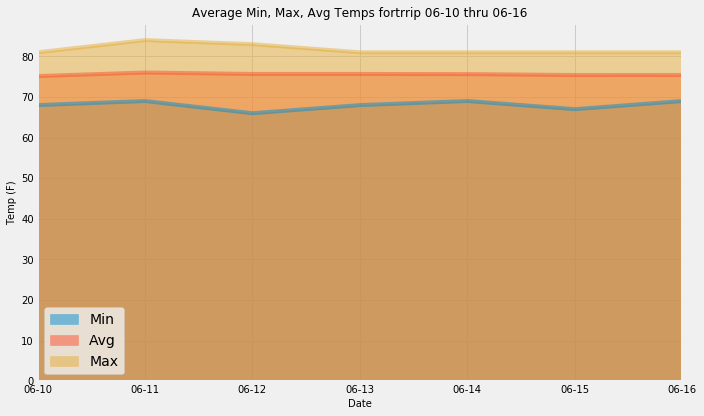

In [223]:
fig,ax = plt.subplots(figsize=(10,6))

normalsDF.plot.area(stacked=False,ax=ax)
plt.title(f'Average Min, Max, Avg Temps fortrrip {formattedDayList[0]} thru {formattedDayList[-1]}',fontsize=12)
plt.xlabel('Date',fontsize=10)
plt.ylabel('Temp (F)', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('./myImages/stackedTemps.png',dpi=300)
plt.show()